In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import os
%load_ext autoreload
%autoreload 2
import importlib
import pickle

## Calibration and Undistorting the image.

### Finding the Image points.

Some chessboard images would not be displayed because all the corners were not found for them.


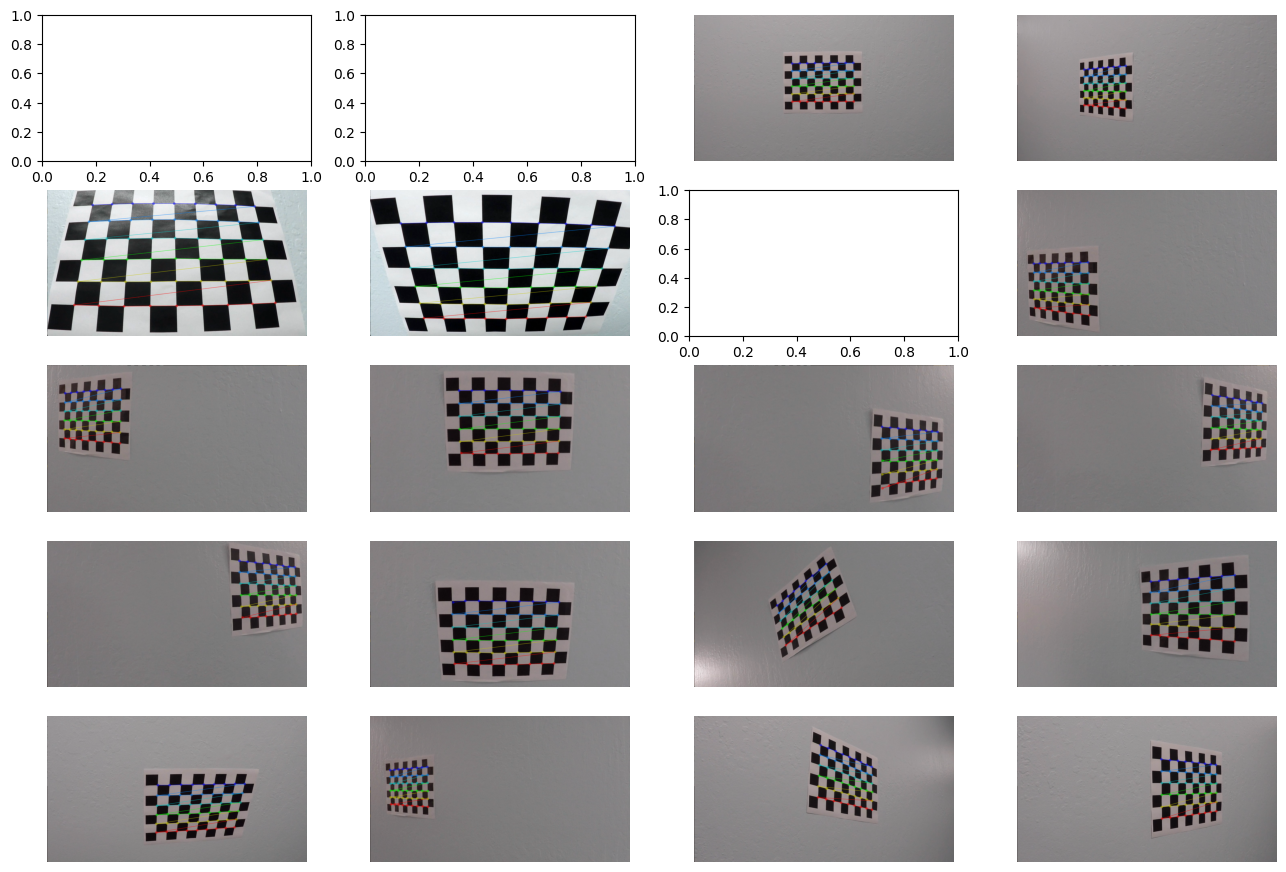

In [2]:
# Object Points- represents the 3D object in the real world space.
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = []
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
axs = axs.ravel()

# Find Chessboard corners for every image.
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)

        imgpoints.append(corners)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)
        cv2.imwrite('output_images/corners_drawn'+str(i)+'.jpg', img)
        
print('Some chessboard images would not be displayed because all the corners were not found for them.')

In [3]:
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

### Evaluating the camera matrix, distortion coefficients and undistortion.

In [4]:
# Calibrating camera with objpoints and imgpoints
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

def undistort(img, mtx, dist):
    undist=cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Saving the camera calibration matrix and coefficients for later use. Ignoring rvecs and tvecs.
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

Text(0.5, 1.0, 'Undistorted Image')

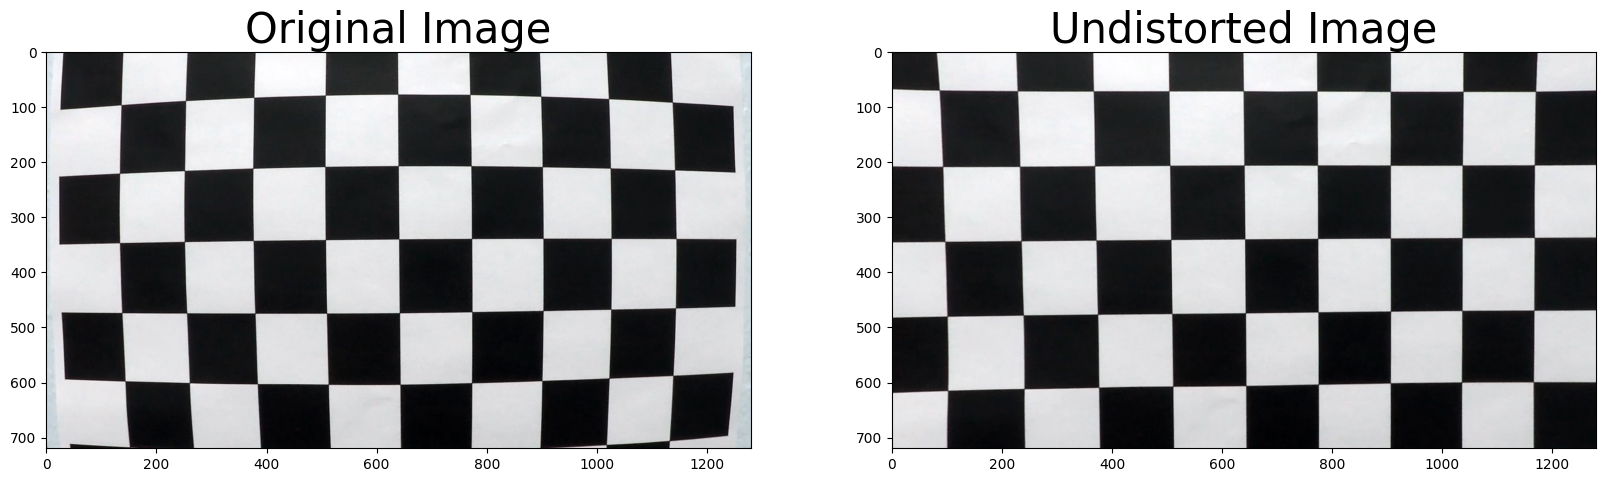

In [5]:
# Visualize undistortion
dst=undistort(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
cv2.imwrite('output_images/original_chessboard.jpg', img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
cv2.imwrite('output_images/undistorted_chessboard.jpg', dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Visualizing undistortion on Road Images.

True

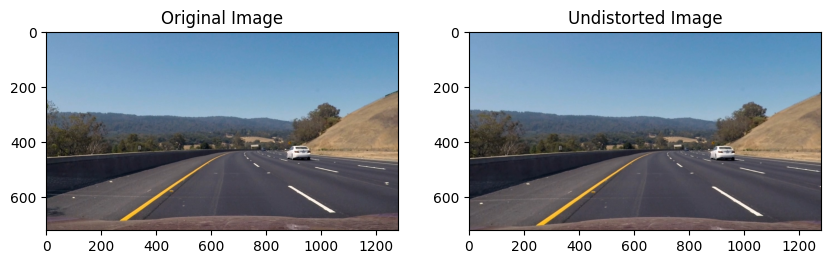

In [6]:
image=mpimg.imread('./test_images/test3.jpg')
undist=undistort(image,mtx,dist)
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(10,10))
ax1.set_title('Original Image')
ax1.imshow(image)
cv2.imwrite('output_images/original_road.jpg', image)
ax2.set_title('Undistorted Image')
ax2.imshow(undist)
cv2.imwrite('output_images/undistorted_road.jpg', undist)

## Sobel Operations and Thresholding

1. Gradients in X or Y direction

2. Magnitude of the gradient.

3. Direction of the gradient.

In [7]:
def abs_sobel_thresh(image,orient,  thresh=(20, 100)):
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    if orient=='x':x, y=1,0
    else: x, y=0,1
        
    sobel=cv2.Sobel(gray,cv2.CV_64F,x,y)
    sobel=np.absolute(sobel)
    scaled_sobel=np.uint8(255*sobel/np.max(sobel))
    
    sx_binary=np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])]=1
    binary_output=np.copy(sx_binary)
    return binary_output


def mag_thresh(img, mag_thresh=(20,150)):
    
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1)
    sobel=np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_sobel=np.uint8(255*sobel/np.max(sobel))
    
#     t=sum((i > 150) &(i<200)  for i in scaled_sobel)
    binary_sobel=np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel>=mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])]=1
    return binary_sobel

def dir_threshold(img,  thresh=(0.7,1.3)):
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx=np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0))
    sobely=np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1))
    
    dir_=np.arctan2(sobely,sobelx)
    
    sx_binary = np.zeros_like(gray)
    sx_binary[(dir_>=thresh[0]) &(dir_<=thresh[1])]=1
    binary_output=sx_binary
    return binary_output

## Visualizing thresholdings.

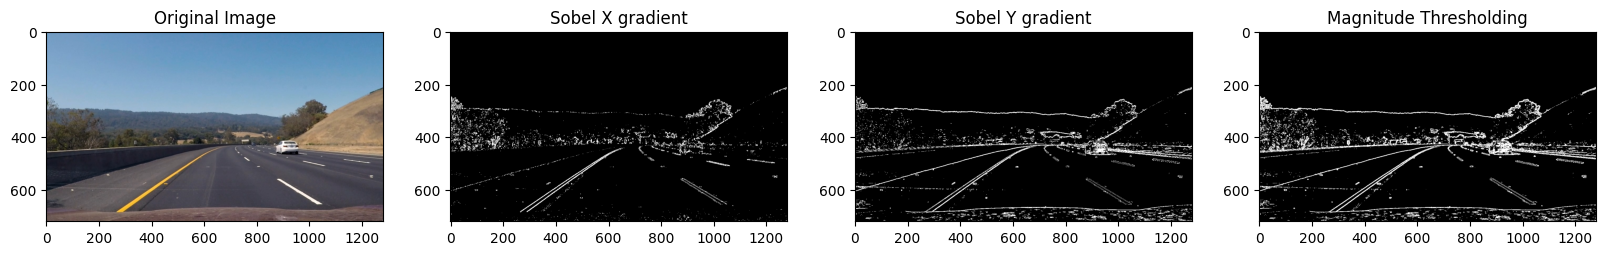

In [8]:
sobelx=abs_sobel_thresh(image, 'x')
sobely=abs_sobel_thresh(image, 'y')
mag_sobel=mag_thresh(image)
dir_sobel=dir_threshold(image)

fig, axes=plt.subplots(1,4, figsize=(20,20))
axes=axes.ravel()

axes[0].set_title('Original Image')
axes[0].imshow(image)
axes[1].set_title('Sobel X gradient')
axes[1].imshow(sobelx, cmap='gray')
axes[2].set_title('Sobel Y gradient')
axes[2].imshow(sobely, cmap='gray')
axes[3].set_title('Magnitude Thresholding')
axes[3].imshow(mag_sobel, cmap='gray')
# axes[4].set_title('Direction Thresholding')
# axes[4].imshow(dir_sobel)

## Thresholding on HLS color channels.

1. Thesholding on S and L channel for detecting Yellow Lane lines.

2. Thresholding on L channel to detect white lane lines.

In [9]:
def color_space(image,thresh=(170,255)):
    hls=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    gray_image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    l_channel=hls[:,:,1]
    s_channel=hls[:,:,2]
    s_binary=np.zeros_like(s_channel)
    
    _, gray_binary = cv2.threshold(gray_image.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    s_binary[(s_channel>=thresh[0]) & (s_channel<=thresh[1])&(l_channel>=80)]=1
    color_output=np.copy(s_binary)
    return color_output

def segregate_white_line(image,thresh=(200,255)):
    hls=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    l_channel=hls[:,:,1]
    l_binary=np.zeros_like(l_channel)
    l_binary[((l_channel>=200)&(l_channel<=255))]=1
    return l_binary


## Combining gradient and color thresholding

In [10]:
def gradient_color_thresh(image):
    ksize=3
    gradx = abs_sobel_thresh(image, orient='x', thresh=(20, 200))
    grady = abs_sobel_thresh(image, orient='y', thresh=(20, 200))
    
    mag_binary = mag_thresh(image, mag_thresh=(20, 200))
    
    dir_binary = dir_threshold(image, thresh=(0.7, 1.3))
    
    color_binary=color_space(image,thresh=(100,255))
    
    combined = np.zeros_like(dir_binary)
    combined[(color_binary==1)|((gradx == 1)& (grady == 1)) |(mag_binary==1) &(dir_binary==1)] = 1
    
    kernel = np.ones((3,3),np.uint8)
    morph_image=combined[600:,:950]
    morph_image = cv2.morphologyEx(morph_image, cv2.MORPH_OPEN, kernel)
    combined[600:,:950]=morph_image
    
    white_line=segregate_white_line(image,thresh=(200,255))
    combined=(combined)|(white_line)
    
    return combined

## Visualizing on a test Image

True

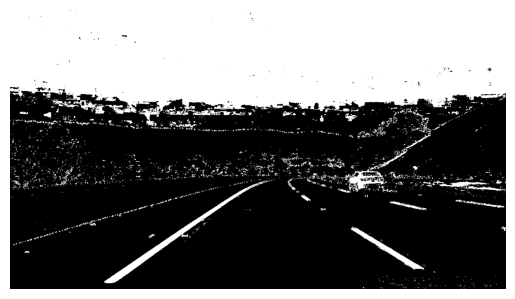

In [11]:
thresh_image=gradient_color_thresh(undist)
plt.imshow(thresh_image, cmap='gray')
plt.axis('off')
cv2.imwrite('output_images/gradient_color_thresh.jpg', thresh_image)

## Perspective Transform

In [12]:
def perspective_transform(image):
    src=np.float32([[195,720],[590,460],[700,460],[1120,720]])
    dst=np.float32([[350,720],[410,0],[970,0],[1000,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size=(image.shape[1],image.shape[0])
    print(M.shape,Minv.shape)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,Minv,M

### Visualiziing Perspective Transform

(3, 3) (3, 3)


(-0.5, 1279.5, 719.5, -0.5)

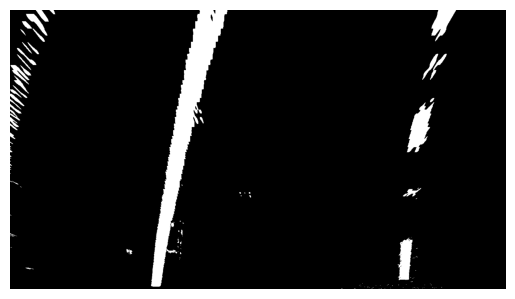

In [13]:
binary_warped,Minv,M=perspective_transform(thresh_image)
plt.imshow(binary_warped, cmap='gray')
plt.axis('off')

## Pipeline to test Image processing and Output on the final Image.

In [14]:
def pipeline(binary_warped,count,image,undist_image):
    if count==0:
        # After creating a warped binary Image,
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set the width of the windows +/- margin
        margin = 100
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
        
        y_eval=700
        mid_x=640
        ym_per_pix=3.0/72.0
        xm_per_pix=3.7/650.0 
        
        c1=(2*right_fit[0]*y_eval+right_fit[1])*xm_per_pix/ym_per_pix
        c2=2*right_fit[0]*xm_per_pix/(ym_per_pix**2)
        
        curvature=((1+c1*c1)**1.5)/(np.absolute(c2))
        
        left_pos=(left_fit[0]*(y_eval**2))+(left_fit[1]*y_eval)+left_fit[2]
        right_pos=(right_fit[0]*(y_eval**2))+(right_fit[1]*y_eval)+right_fit[2]
        
        dx=((left_pos+right_pos)/2-mid_x)*xm_per_pix
        if dx>0:
            text='Left'
        else:
            text='Right'
        
        font=cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(result,'Radius of curvature  = %.2f m'%(curvature),(20,50), font, 1,(255,255,255),2,cv2.LINE_AA)
        
        cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(dx), text),(20,90),
                        font, 1,(255,255,255),2,cv2.LINE_AA)
        
        return result

/Users/apeksha/.pyenv/versions/3.7.17/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == "":
/Users/apeksha/.pyenv/versions/3.7.17/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your

(-0.5, 1279.5, 719.5, -0.5)

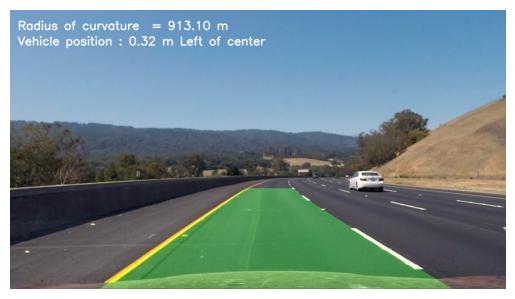

In [15]:
count=0
result=pipeline(binary_warped,count,image,undist)
plt.imshow(result)
plt.axis('off')

## Creating a Line class to store data.

In [16]:
class line():
    def __init__(self):
        self.first_frame=False
        self.curvature=0
        
        self.right_fit=[np.array([False])]
        self.left_fit=[np.array([True])]
        self.max_tolerance=0.01
        
        self.img=None
        self.y_eval=700
        self.mid_x=640
        self.ym_per_pix=3.0/72.0
        self.xm_per_pix=3.7/650.0 #HardCoded
    
    def update_fit(self,left_fit,right_fit):
        if self.first_frame:
            error_left=((self.left_fit[0]-left_fit[0])**2).mean(axis=None)
            error_right=((self.right_fit[0]-right_fit[0])**2).mean(axis=None)
            if error_left<self.max_tolerance:
                self.left_fit=0.75*self.left_fit+0.25*left_fit
            if error_right<self.max_tolerance:
                self.right_fit=0.75*self.right_fit+0.25*right_fit
        
        else:
            self.right_fit=right_fit
            self.left_fit=left_fit
        
        self.update_curvature(self.right_fit)
        
    def update_curvature(self,fit):
        
        c1=(2*fit[0]*self.y_eval+fit[1])*self.xm_per_pix/self.ym_per_pix
        c2=2*fit[0]*self.xm_per_pix/(self.ym_per_pix**2)
        
        curvature=((1+c1*c1)**1.5)/(np.absolute(c2))
        
        if self.first_frame:
            self.curvature=curvature
        
        elif np.absolute(curvature-self.curvature)<500:
            self.curvature=0.75*self.curvature + 0.25* curvature
        
    def vehicle_position(self):
        left_pos=(self.left_fit[0]*(self.y_eval**2))+(self.left_fit[1]*self.y_eval)+self.left_fit[2]
        right_pos=(self.right_fit[0]*(self.y_eval**2))+(self.right_fit[1]*self.y_eval)+self.right_fit[2]
        
        return ((left_pos+right_pos)/2.0 - self.mid_x)*self.xm_per_pix

## Final Pipeline class for finding lane lines in real time.

In [17]:
class pipeline:
    line=None
    M=None
    Minv=None
    camera_mtx=None
    dist=None
    
    @staticmethod
    def set_vals(l,camera_mtx,dist,m,minv):
        pipeline.line=l
        pipeline.camera_mtx=camera_mtx
        pipeline.dist=dist
        pipeline.M=M
        pipeline.Minv=Minv
    
    @staticmethod
    def Pipeline(img):
        line,M,Minv,camera_mtx,dist=pipeline.line,pipeline.M,pipeline.Minv,pipeline.camera_mtx,pipeline.dist
        
        img_size=(img.shape[1],img.shape[0])
        width,height=img_size
        
        undist_img=undistort(np.copy(img),camera_mtx,dist)
        thresh_image=gradient_color_thresh(undist_img)
        
        binary_warped = cv2.warpPerspective(thresh_image, M, img_size, flags=cv2.INTER_LINEAR)
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        nwindows = 9
        
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        margin = 100
        minpix=50
        
        if not line.first_frame:
            histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
            # Create an output image to draw on and  visualize the result
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,0), 2) 
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 

            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            
            line.update_fit(left_fit,right_fit)
            line.first_frame=True
            
        else:
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            left_fit=line.left_fit
            right_fit=line.right_fit
            
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
            left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
            left_fit[1]*nonzeroy + left_fit[2] + margin))) 

            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
            right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
            right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            
            line.update_fit(left_fit,right_fit)
            left_fit=line.left_fit
            right_fit=line.right_fit
         
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        dx=line.vehicle_position()
        if dx>0:
            text='Left'
        else:
            text='Right'
        
        cv2.putText(result,'Radius of curvature  = %.2f m'%(line.curvature),(20,50), font, 1,(255,255,255),2,cv2.LINE_AA)
        
        cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(dx), text),(20,90),
                        font, 1,(255,255,255),2,cv2.LINE_AA)
        return result

In [18]:
import os
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/Cellar/ffmpeg/7.1/bin/ffmpeg"

In [19]:
from moviepy.editor import VideoFileClip
# from IPython.display import HTML

In [20]:
line_=line()
pipeline.set_vals(line_,mtx,dist,M,Minv)
video_output = 'output_videos/video2.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline.Pipeline)
%time video_clip.write_videofile(video_output, audio=False)

Moviepy - Building video output_videos/video2.mp4.
Moviepy - Writing video output_videos/video2.mp4



Moviepy - Done !
Moviepy - video ready output_videos/video2.mp4
CPU times: user 1min 28s, sys: 20.7 s, total: 1min 48s
Wall time: 1min 34s
